In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import json
from tqdm import tqdm
import torch.nn.functional as F  # Add this import at the top
from tqdm import tqdm
import os
import sys
# Get the notebook's directory
notebook_dir = os.getcwd()
# Add parent directory to path
project_root = os.path.dirname(notebook_dir)
sys.path.append(project_root)

 checking if the MPS (Metal Performance Shaders) backend is available

In [2]:
# Check if MPS is available
if not torch.backends.mps.is_available():
    raise RuntimeError("MPS device not available. Check if PyTorch and macOS set up correctly.")

# Set the device to MPS
device = torch.device("mps")  # Use GPU on M2 Pro

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from QKD_Functions.QKD_Functions import (
    calculate_factorial,
    calculate_tau_n,
    calculate_eta_ch,
    calculate_eta_sys,
    calculate_D_mu_k,
    calculate_n_X_total,
    calculate_N,
    calculate_n_Z_total,
    calculate_e_mu_k,
    calculate_e_obs,
    calculate_h,
    calculate_lambda_EC,
    calculate_sqrt_term,
    calculate_tau_n,
    calculate_n_pm, 
    calculate_S_0,
    calculate_S_1,
    calculate_m_mu_k,
    calculate_m_pm,
    calculate_v_1,
    calculate_gamma,
    calculate_Phi,
    calculate_LastTwoTerm,
    calculate_l,
    calculate_R,
    experimental_parameters,
    other_parameters,
    calculate_key_rates_and_metrics,
    penalty, 
    objective,
    objective_with_logging
)

/Users/daai6ga1hou2/anaconda3/envs/qkd-training_set/lib/python3.9/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
class BB84NN(nn.Module):
    def __init__(self):
        super(BB84NN, self).__init__()
        self.fc1 = nn.Linear(4,128)
        self.fc2 = nn.Linear(128,256)
        self.fc3 = nn.Linear(256, 512)  # Change 64 -> 32 to match checkpoint
        self.fc4 = nn.Linear(512, 1024)  # Change 64 -> 16 to match checkpoint
        self.fc5 = nn.Linear(1024, 512)
        self.fc6 = nn.Linear(512, 256)
        self.fc7 = nn.Linear(256, 128)
        self.fc8 = nn.Linear(128, 64)  # Change 32 -> 16 to match checkpoint
        self.fc9 = nn.Linear(64, 5)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = F.relu(self.fc8(x))
        x = self.fc9(x)
        
        return x

In [5]:
# Load dataset
with open('../Training_Data/combined_datasets.json', 'r') as f:
    data_by_nx = json.load(f)

print(f"The overall dataset contains {len(data_by_nx)} entries.")

# Verify the length of the list associated with the first key
first_key = list(data_by_nx.keys())[0]
print(f"The number of entries associated with the first key ({first_key}) is: {len(data_by_nx[first_key])}")

# Flatten the data structure and filter
cleaned_data = []
for n_x, entries in data_by_nx.items():
    cleaned_data.extend([
        item for item in entries
# if item["key_rate"] > 0 and 
if item["e_1"] * 100 <= 200  # Only positive key rates and fiber lengths <= 200 km
    ])

# Optional: Verify the cleaned dataset
if not cleaned_data:
    print("No valid data after filtering.")
else:
    print(f"Filtered dataset contains {len(cleaned_data)} entries.")
    print("\nSample entry from the cleaned dataset:")
    print(json.dumps(cleaned_data[0], indent=2))
    print("\nNumber of unique n_X values:", len(data_by_nx))

The overall dataset contains 4 entries.
The number of entries associated with the first key (1000000.0) is: 1000
Filtered dataset contains 4000 entries.

Sample entry from the cleaned dataset:
{
  "fiber_length": 0.1,
  "e_1": 0.001,
  "e_2": 6.221848749616356,
  "e_3": 0.5,
  "e_4": 6.0,
  "key_rate": 0.0036303286417213275,
  "optimized_params": {
    "mu_1": 0.5549018921354658,
    "mu_2": 0.26969689565760935,
    "P_mu_1": 0.12707388827527158,
    "P_mu_2": 0.7359624876233963,
    "P_X_value": 0.662917960144376
  }
}

Number of unique n_X values: 4


In [6]:
Y = []
for item in cleaned_data:
    mu_1, mu_2, P_mu_1, P_mu_2, P_X = item['optimized_params'].values()
    # Constraints applied but not stored in Y
    # P_mu_3 = max(1 - (P_mu_1 + P_mu_2), 1e-6)
    # P_Z = max(1 - P_X, 1e-6)
    
    # Store only the first five parameters
    Y.append([mu_1, mu_2, P_mu_1, P_mu_2, P_X])

Y = np.array(Y, dtype=np.float32)

In [7]:
# Separate features (X) and targets (Y)
X = np.array([[item['e_1'], item['e_2'], item['e_3'], item['e_4']] for item in cleaned_data], dtype=np.float32)
Y = np.array([list(item['optimized_params'].values()) for item in cleaned_data ], dtype=np.float32)  # Flatten dictionary

# Shuffle the data
from sklearn.utils import shuffle
X, Y = shuffle(X, Y, random_state=42)

# Split the dataset into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=42)

# Scale the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit and transform on training data
X_val = scaler.transform(X_val)  # Transform validation data using the same scaler

from sklearn.preprocessing import MinMaxScaler

y_scaler = MinMaxScaler()  # Scale targets to [0, 1]
Y_train = y_scaler.fit_transform(Y_train)
Y_val = y_scaler.transform(Y_val)

import joblib
joblib.dump(scaler, 'scaler.pkl')  # Save StandardScaler
joblib.dump(y_scaler, 'y_scaler.pkl')  # Save MinMaxScaler

print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_val shape: {X_val.shape}, Y_val shape: {Y_val.shape}")

X_train shape: (2800, 4), Y_train shape: (2800, 5)
X_val shape: (1200, 4), Y_val shape: (1200, 5)


In [8]:
# Convert dataset to PyTorch tensors
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(Y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(Y_val, dtype=torch.float32))

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)

# Initialize model
model = BB84NN().to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Adam optimizer

# Learning rate scheduler
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20)

In [9]:
def validate_and_check_constraints(model, val_loader, criterion, device, bounds):
    model.eval()
    total_loss = 0
    constraint_violations = 0

    with torch.no_grad():
        for X_batch, Y_batch in val_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            predictions = model(X_batch)
            
            # Calculate loss
            loss = criterion(predictions, Y_batch)
            total_loss += loss.item()
            
            # Check constraints
            for i, bound in enumerate(bounds):
                lower, upper = bound
                # Check if any predictions are out of the specified bounds
                if (predictions[:, i] < lower).any() or (predictions[:, i] > upper).any():
                    constraint_violations += 1

    avg_loss = total_loss / len(val_loader)
    print(f"Validation Loss: {avg_loss:.4f}")
    if constraint_violations == 0:
        print("All constraints satisfied.")
    else:
        print(f"Constraints violated in {constraint_violations} batches.")

    return avg_loss, constraint_violations

In [10]:
num_epochs = 5000
best_loss = float('inf')  # Initialize best loss to infinity
patience = 20 # Number of epochs to wait before stopping
best_val_loss = float('inf')
early_stop_counter = 0
early_stopping_patience = 100  # Early stopping patience

# Initialize placeholders for final outputs
final_train_loss = None
final_val_loss = None

# Bounds for predicted parameters (adjust as needed)
bounds = [
    (4e-4, 0.9),  
    (2e-4, 0.5),  
    (1e-12, 1.0 - 1e-12),  
    (1e-12, 1.0- 1e-12),  
    (1e-12, 1.0- 1e-12),  
]

In [11]:
# Fixed QKD Parameters (create this OUTSIDE the loss function)
# qkd_params = (0.2, 0.1, 6e-7, 1e-10, 1e-15, 1.16, 0.01, 1) #alpha, eta_Bob, P_dc_value, epsilon_sec, 

# Fixed parameters
alpha = 0.2
eta_Bob = 0.1
P_dc_value = 6e-7
epsilon_sec = 1e-10
epsilon_cor = 1e-15
f_EC = 1.16
e_mis = 5e-3
P_ap = 0 #4e-2
n_event = 1

parameter_criterion = nn.MSELoss()

def compute_loss(predictions, targets, X_batch, n_X):
    # Calculate standard loss (e.g., MSE)
    # loss = criterion(predictions, targets)
    
    parameter_loss = nn.MSELoss()(predictions, targets)
    
    return parameter_loss

In [12]:
def validate(model, val_loader, criterion, device):
    """
    Perform validation and calculate average loss.
    Args:
        model (nn.Module): The model to validate.
        val_loader (DataLoader): DataLoader for the validation set.
        criterion (nn.Module): Loss function.
        device (torch.device): Device to perform computation.
    Returns:
        float: Average validation loss.
    """
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    with torch.no_grad():
        for X_batch, Y_batch in val_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            predictions = model(X_batch)
            loss = criterion(predictions, Y_batch)
            val_loss += loss.item()

    val_loss /= len(val_loader)  # Average validation loss
    return val_loss


In [13]:
def check_constraints(predictions, bounds):
    # """Checks if predictions satisfy the given bounds."""
    # for i, (lower, upper) in enumerate(bounds):
    #     if not (torch.all(predictions[:, i] >= lower) and torch.all(predictions[:, i] <= upper)):
    #         return False
    return True

max_retries = 1

for epoch in tqdm(range(num_epochs), desc="Training Progress"):
    model.train()
    train_loss = 0  # Track training loss for this epoch

    # Inside the training
    for X_batch, Y_batch in train_loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        print("Shape of X_batch:", X_batch.shape)
        print("Shape of Y_batch:", Y_batch.shape)
        # Print the first few values to check their range
        print("Sample from X_batch:", X_batch[0])
        print("Sample from Y_batch:", Y_batch[0])
        optimizer.zero_grad()
        
        predictions = model(X_batch.to(device))
        # batch_loss = compute_loss(predictions, Y_batch.to(device), bounds=bounds)
        batch_loss = compute_loss(predictions, Y_batch.to(device), X_batch, 1e8)
        batch_loss.backward()
        
        # Gradient clipping to avoid exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        train_loss += batch_loss.item()
        train_loss /= len(train_loader)

    # Validation step
    current_val_loss = validate(model, val_loader, criterion, device)
    # val_loss, violations = validate_and_check_constraints(model, val_loader, criterion, device, bounds)
    # Print training and validation loss for the epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {current_val_loss:.4f}")

    # # Learning rate adjustment
    scheduler.step(current_val_loss)
        
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        early_stop_counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        early_stop_counter += 1
        
    if early_stop_counter >= patience:
        print("Early stopping triggered. Training complete.")
        break

Training Progress:   0%|          | 0/5000 [00:00<?, ?it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 1.3792,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.0025, 0.2150, 0.7397, 0.1692, 0.0831], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.4586,  0.0000,  0.0000,  1.3229], device='mps:0')
Sample from Y_batch: tensor([0.5266, 0.9327, 0.1295, 0.9278, 0.9867], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.3363,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.8947, 0.6432, 0.0014, 0.9470, 0.7196], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 1.1071,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.1037, 0.3794, 0.3689, 0.4462, 0.1898], device='mps:0')
Shape of X_batch

Training Progress:   0%|          | 1/5000 [00:01<1:31:28,  1.10s/it]

Epoch 1/5000, Train Loss: 0.0041, Val Loss: 0.0855
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.9675,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.8889, 0.6415, 0.0050, 0.9415, 0.7121], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.5310,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.7404, 0.7671, 0.0383, 0.9433, 0.8240], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 1.2826,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.0025, 0.2150, 0.7397, 0.1692, 0.0831], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.5481,  0.0000,  0.0000,  1.3229], device='mps:0')
Sample from Y_batch: tensor([0.5451, 0.9804, 0.0858

Training Progress:   0%|          | 2/5000 [00:01<55:04,  1.51it/s]  

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.3964, 0.0000, 0.0000, 1.3229], device='mps:0')
Sample from Y_batch: tensor([0.1523, 0.0092, 0.9962, 0.0027, 0.1399], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.1033, 0.0000, 0.0000, 1.3229], device='mps:0')
Sample from Y_batch: tensor([0.1523, 0.0092, 0.9962, 0.0027, 0.1399], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.3793,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.7575, 0.7713, 0.0451, 0.9320, 0.8119], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.7401,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.9167, 0.6475, 0.0097, 0.9349, 0.7021], device='mps:0')
Shape of X_batch: torch.

Training Progress:   0%|          | 3/5000 [00:01<43:57,  1.89it/s]

tensor([-0.3172,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.7353, 0.7732, 0.0503, 0.9155, 0.8032], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 1.6378,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.1037, 0.3794, 0.3689, 0.4462, 0.1898], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.6936,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.1037, 0.3794, 0.3689, 0.4462, 0.1898], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.2826, 0.0000, 0.0000, 1.3229], device='mps:0')
Sample from Y_batch: tensor([0.1523, 0.0092, 0.9962, 0.0027, 0.1399], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 1.0930,  0.

Training Progress:   0%|          | 4/5000 [00:02<38:44,  2.15it/s]

tensor([-0.8792,  0.0000,  0.0000,  0.4325], device='mps:0')
Sample from Y_batch: tensor([0.6530, 0.8691, 0.0663, 0.9873, 0.9273], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 1.3208,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.1037, 0.3794, 0.3689, 0.4462, 0.1898], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.5654, 0.0000, 0.0000, 0.4325], device='mps:0')
Sample from Y_batch: tensor([0.0617, 0.1323, 0.8923, 0.0702, 0.1729], device='mps:0')
Shape of X_batch: torch.Size([112, 4])
Shape of Y_batch: torch.Size([112, 5])
Sample from X_batch: tensor([-0.7930,  0.0000,  0.0000,  1.3229], device='mps:0')
Sample from Y_batch: tensor([0.5163, 0.9402, 0.1040, 0.9655, 0.9961], device='mps:0')
Epoch 4/5000, Train Loss: 0.0003, Val Loss: 0.0049
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size(

Training Progress:   0%|          | 5/5000 [00:02<35:33,  2.34it/s]

Epoch 5/5000, Train Loss: 0.0001, Val Loss: 0.0024
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.7379, 0.0000, 0.0000, 1.3229], device='mps:0')
Sample from Y_batch: tensor([0.1523, 0.0092, 0.9962, 0.0027, 0.1399], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 1.4585,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.0025, 0.2150, 0.7397, 0.1692, 0.0831], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.3448,  0.0000,  0.0000,  0.4325], device='mps:0')
Sample from Y_batch: tensor([0.6180, 0.8657, 0.0831, 0.9381, 0.9091], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.5057,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.9736, 0.6597, 0.0189, 0.

Training Progress:   0%|          | 6/5000 [00:02<34:51,  2.39it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.0353,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.4202, 0.5878, 0.1134, 0.6644, 0.4799], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.1792, 0.0000, 0.0000, 0.4325], device='mps:0')
Sample from Y_batch: tensor([0.0617, 0.1323, 0.8923, 0.0702, 0.1729], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.3482,  0.0000,  0.0000,  0.4325], device='mps:0')
Sample from Y_batch: tensor([0.6144, 0.8872, 0.0585, 0.9956, 0.9319], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.1861,  0.0000,  0.0000,  0.4325], device='mps:0')
Sample from Y_batch: tensor([0.6136, 0.8797, 0.0603, 0.9936, 0.9309], device='mps:0')
Shape of X_batch: to

Training Progress:   0%|          | 7/5000 [00:03<33:57,  2.45it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 1.3481,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.0025, 0.2150, 0.7397, 0.1692, 0.0831], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.3102,  0.0000,  0.0000,  1.3229], device='mps:0')
Sample from Y_batch: tensor([0.5291, 0.9605, 0.0937, 0.9862, 0.9985], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.2972,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.1091, 0.3850, 0.3617, 0.4529, 0.1989], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.1827,  0.0000,  0.0000,  1.3229], device='mps:0')
Sample from Y_batch: tensor([0.5359, 0.9519, 0.0998, 0.9800, 0.9977], device='mps:0')
Shape of X_batch

Training Progress:   0%|          | 8/5000 [00:03<33:15,  2.50it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.5000,  0.0000,  0.0000,  0.4325], device='mps:0')
Sample from Y_batch: tensor([0.6347, 0.8646, 0.0718, 0.9625, 0.9199], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.3447,  0.0000,  0.0000,  1.3229], device='mps:0')
Sample from Y_batch: tensor([0.5291, 0.9630, 0.0923, 0.9876, 0.9986], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 1.7136,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.1037, 0.3794, 0.3689, 0.4462, 0.1898], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.7172,  0.0000,  0.0000,  0.4325], device='mps:0')
Sample from Y_batch: tensor([0.6109, 0.8654, 0.0634, 0.9740, 0.9271], device='mps:0')
Shape of X_batch

Training Progress:   0%|          | 9/5000 [00:04<31:57,  2.60it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.3517, 0.0000, 0.0000, 0.4325], device='mps:0')
Sample from Y_batch: tensor([0.0504, 0.4263, 0.7080, 0.2271, 0.5222], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.8482,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.7598, 0.7727, 0.0372, 0.9744, 0.8327], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.1999,  0.0000,  0.0000,  1.3229], device='mps:0')
Sample from Y_batch: tensor([0.5344, 0.9530, 0.0989, 0.9809, 0.9978], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.1387,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.3300, 0.5416, 0.1603, 0.6310, 0.4179], device='mps:0')
Shape of X_batch: to

Training Progress:   0%|          | 10/5000 [00:04<32:31,  2.56it/s]

tensor([-0.2345,  0.0000,  0.0000,  0.4325], device='mps:0')
Sample from Y_batch: tensor([0.6038, 0.8694, 0.0928, 0.9235, 0.8994], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.0723,  0.0000,  0.0000,  1.3229], device='mps:0')
Sample from Y_batch: tensor([0.5074, 0.9470, 0.0934, 0.9776, 0.9988], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.8986,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.8947, 0.6427, 0.0062, 0.9399, 0.7097], device='mps:0')
Shape of X_batch: torch.Size([112, 4])
Shape of Y_batch: torch.Size([112, 5])
Sample from X_batch: tensor([ 0.6689,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.0025, 0.2150, 0.7397, 0.1692, 0.0831], device='mps:0')
Epoch 10/5000, Train Loss: 0.0000, Val Loss: 0.0005
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.

Training Progress:   0%|          | 11/5000 [00:04<31:29,  2.64it/s]

Epoch 11/5000, Train Loss: 0.0000, Val Loss: 0.0005
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.0801,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.3855, 0.5705, 0.1301, 0.6533, 0.4566], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.1793, 0.0000, 0.0000, 1.3229], device='mps:0')
Sample from Y_batch: tensor([0.1641, 0.6750, 0.6148, 0.3308, 0.8005], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.8211,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.1037, 0.3794, 0.3689, 0.4462, 0.1898], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.3758,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.0222, 0.3336, 0.6467, 0

Training Progress:   0%|          | 12/5000 [00:05<31:05,  2.67it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.1783,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.5236, 0.6375, 0.0683, 0.6884, 0.5494], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.4672,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([9.1399e-01, 6.4788e-01, 7.8343e-04, 9.4824e-01, 7.2097e-01],
       device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.8469,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.9006, 0.6440, 0.0072, 0.9385, 0.7076], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.4724,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.0000, 0.1974, 0.7519, 0.1588, 0.0309], devic

Training Progress:   0%|          | 13/5000 [00:05<30:31,  2.72it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.4259,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.9067, 0.6461, 0.0010, 0.9479, 0.7206], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.1896,  0.0000,  0.0000,  1.3229], device='mps:0')
Sample from Y_batch: tensor([0.4987, 0.9367, 0.1493, 0.8992, 0.9723], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.1689, 0.0000, 0.0000, 1.3229], device='mps:0')
Sample from Y_batch: tensor([0.1523, 0.0092, 0.9962, 0.0027, 0.1399], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.6964, 0.0000, 0.0000, 0.4325], device='mps:0')
Sample from Y_batch: tensor([0.0617, 0.1323, 0.8923, 0.0702, 0.1729], device='mps:0')
Shape of X_batch: torch.

Training Progress:   0%|          | 14/5000 [00:05<30:03,  2.77it/s]

tensor([0.5812, 1.0000, 0.0816, 0.9990, 1.0000], device='mps:0')
Shape of X_batch: torch.Size([112, 4])
Shape of Y_batch: torch.Size([112, 5])
Sample from X_batch: tensor([ 0.4862,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.0000, 0.1974, 0.7519, 0.1588, 0.0309], device='mps:0')
Epoch 14/5000, Train Loss: 0.0000, Val Loss: 0.0005
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.0413,  0.0000,  0.0000,  0.4325], device='mps:0')
Sample from Y_batch: tensor([0.6254, 0.8744, 0.0626, 0.9912, 0.9296], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.3827,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.0190, 0.3174, 0.6608, 0.2382, 0.2588], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.5412,  0.0000,  0.0000, -0.4579], d

Training Progress:   0%|          | 15/5000 [00:06<30:00,  2.77it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.3466,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.8958, 0.6435, 0.0014, 0.9471, 0.7197], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.3937,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.1037, 0.3794, 0.3689, 0.4462, 0.1898], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.1655,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.1993, 0.6369, 0.2840, 0.5779, 0.5769], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.8211,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.1037, 0.3794, 0.3689, 0.4462, 0.1898], device='mps:0')
Shape of X_batch

Training Progress:   0%|          | 16/5000 [00:06<29:38,  2.80it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.6861, 0.0000, 0.0000, 0.4325], device='mps:0')
Sample from Y_batch: tensor([0.0617, 0.1323, 0.8923, 0.0702, 0.1729], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.1655,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.1993, 0.6369, 0.2840, 0.5779, 0.5769], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.8435,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.9010, 0.6441, 0.0072, 0.9384, 0.7074], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.2930,  0.0000,  0.0000,  1.3229], device='mps:0')
Sample from Y_batch: tensor([0.5295, 0.9593, 0.0944, 0.9855, 0.9984], device='mps:0')
Shape of X_batch: to

Training Progress:   0%|          | 17/5000 [00:06<30:17,  2.74it/s]

tensor([0.4721, 0.6131, 0.0904, 0.6780, 0.5143], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.3688,  0.0000,  0.0000,  0.4325], device='mps:0')
Sample from Y_batch: tensor([0.6156, 0.8883, 0.0583, 0.9958, 0.9320], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.1163,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.5016, 0.6271, 0.0778, 0.6843, 0.5341], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.2310,  0.0000,  0.0000,  1.3229], device='mps:0')
Sample from Y_batch: tensor([0.5060, 0.9362, 0.1456, 0.9047, 0.9756], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.5275, 0.0000, 0.0000, 1.3229], device='mps:0')
Sample from Y_batch: tensor([0.1521, 0.01

Training Progress:   0%|          | 18/5000 [00:07<29:52,  2.78it/s]

Shape of X_batch: torch.Size([112, 4])
Shape of Y_batch: torch.Size([112, 5])
Sample from X_batch: tensor([-0.1172,  0.0000,  0.0000,  1.3229], device='mps:0')
Sample from Y_batch: tensor([0.4817, 0.9373, 0.1570, 0.8880, 0.9649], device='mps:0')
Epoch 18/5000, Train Loss: 0.0000, Val Loss: 0.0005
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.7763,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.1037, 0.3794, 0.3689, 0.4462, 0.1898], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 1.4826,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.0025, 0.2150, 0.7397, 0.1692, 0.0831], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.2379,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.1309, 0.5706, 0.373

Training Progress:   0%|          | 19/5000 [00:07<29:58,  2.77it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.4585,  0.0000,  0.0000,  1.3229], device='mps:0')
Sample from Y_batch: tensor([0.5344, 0.9719, 0.0885, 0.9916, 0.9991], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.3517,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.0350, 0.3874, 0.5958, 0.2962, 0.3411], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.6620, 0.0000, 0.0000, 0.4325], device='mps:0')
Sample from Y_batch: tensor([0.0617, 0.1323, 0.8923, 0.0702, 0.1729], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.0033, 0.0000, 0.0000, 0.4325], device='mps:0')
Sample from Y_batch: tensor([0.0617, 0.1323, 0.8923, 0.0702, 0.1729], device='mps:0')
Shape of X_batch: torch.

Training Progress:   0%|          | 20/5000 [00:08<29:28,  2.82it/s]

tensor([0.1800, 0.7486, 0.3531, 0.5513, 0.7417], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.4190,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.9056, 0.6459, 0.0010, 0.9478, 0.7205], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.1724,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.1931, 0.6318, 0.2908, 0.5720, 0.5723], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.3162,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.8595, 0.6529, 0.0187, 0.8571, 0.6594], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.4275,  0.0000,  0.0000,  1.3229], device='mps:0')
Sample from Y_batch: tensor([0.5320, 

Training Progress:   0%|          | 21/5000 [00:08<29:23,  2.82it/s]

tensor([0.6082, 0.8655, 0.0621, 0.9756, 0.9280], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.4447, 0.0000, 0.0000, 0.4325], device='mps:0')
Sample from Y_batch: tensor([0.0617, 0.1323, 0.8923, 0.0702, 0.1729], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.4688,  0.0000,  0.0000,  0.4325], device='mps:0')
Sample from Y_batch: tensor([0.6253, 0.8947, 0.0573, 0.9969, 0.9325], device='mps:0')
Shape of X_batch: torch.Size([112, 4])
Shape of Y_batch: torch.Size([112, 5])
Sample from X_batch: tensor([ 1.0758,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.0025, 0.2150, 0.7397, 0.1692, 0.0831], device='mps:0')
Epoch 21/5000, Train Loss: 0.0001, Val Loss: 0.0006
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.9034,  0.0000,  0.0000,  1.3229], devic

Training Progress:   0%|          | 22/5000 [00:08<29:09,  2.84it/s]

Epoch 22/5000, Train Loss: 0.0000, Val Loss: 0.0005
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.2275,  0.0000,  0.0000,  1.3229], device='mps:0')
Sample from Y_batch: tensor([0.5324, 0.9548, 0.0974, 0.9824, 0.9980], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.2413, 0.0000, 0.0000, 0.4325], device='mps:0')
Sample from Y_batch: tensor([0.0617, 0.1323, 0.8923, 0.0702, 0.1729], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.5224,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([9.2567e-01, 6.5070e-01, 5.6358e-04, 9.4872e-01, 7.2147e-01],
       device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.6930, 0.0000, 0.0000, 0.4325], device='mps:0')
Sample from Y_batch: tensor([0.

Training Progress:   0%|          | 23/5000 [00:09<29:43,  2.79it/s]

tensor([0.0025, 0.2150, 0.7397, 0.1692, 0.0831], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.7103,  0.0000,  0.0000,  0.4325], device='mps:0')
Sample from Y_batch: tensor([0.6115, 0.8654, 0.0636, 0.9737, 0.9269], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 1.5792,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.1037, 0.3794, 0.3689, 0.4462, 0.1898], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.4724,  0.0000,  0.0000,  1.3229], device='mps:0')
Sample from Y_batch: tensor([0.5272, 0.9325, 0.1287, 0.9289, 0.9871], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.0345,  0.0000,  0.0000,  1.3229], device='mps:0')
Sample from Y_batch: tensor([0.2176, 

Training Progress:   0%|          | 24/5000 [00:09<30:01,  2.76it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.4127,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.8728, 0.6462, 0.0121, 0.8760, 0.6773], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 1.6998,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.0025, 0.2150, 0.7397, 0.1692, 0.0831], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.9176,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.1037, 0.3794, 0.3689, 0.4462, 0.1898], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.9245,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.1037, 0.3794, 0.3689, 0.4462, 0.1898], device='mps:0')
Shape of X_batch

Training Progress:   0%|          | 25/5000 [00:09<30:06,  2.75it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.4378,  0.0000,  0.0000,  0.4325], device='mps:0')
Sample from Y_batch: tensor([0.6216, 0.8926, 0.0576, 0.9966, 0.9323], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.8172,  0.0000,  0.0000,  0.4325], device='mps:0')
Sample from Y_batch: tensor([0.6051, 0.8658, 0.0606, 0.9777, 0.9291], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 1.4171,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.0025, 0.2150, 0.7397, 0.1692, 0.0831], device='mps:0')
Shape of X_batch: torch.Size([112, 4])
Shape of Y_batch: torch.Size([112, 5])
Sample from X_batch: tensor([ 1.6792,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.1037, 0.3794, 0.3689, 0.4462, 0.1898], device='mps:0')
Epoch 25/5000, T

Training Progress:   1%|          | 26/5000 [00:10<29:38,  2.80it/s]

Epoch 26/5000, Train Loss: 0.0000, Val Loss: 0.0004
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.3673,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.8983, 0.6441, 0.0013, 0.9473, 0.7199], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.1275,  0.0000,  0.0000,  1.3229], device='mps:0')
Sample from Y_batch: tensor([0.5419, 0.9482, 0.1032, 0.9765, 0.9973], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.2507,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.8455, 0.6602, 0.0257, 0.8447, 0.6443], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.4103,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.7535, 0.7704, 0.043

Training Progress:   1%|          | 27/5000 [00:10<29:33,  2.80it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.1482,  0.0000,  0.0000,  1.3229], device='mps:0')
Sample from Y_batch: tensor([0.5394, 0.9496, 0.1019, 0.9779, 0.9975], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 1.5896,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.1037, 0.3794, 0.3689, 0.4462, 0.1898], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.8310, 0.0000, 0.0000, 1.3229], device='mps:0')
Sample from Y_batch: tensor([0.1523, 0.0092, 0.9962, 0.0027, 0.1399], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.6861,  0.0000,  0.0000,  0.4325], device='mps:0')
Sample from Y_batch: tensor([0.6730, 0.9157, 0.0551, 0.9996, 0.9334], device='mps:0')
Shape of X_batch: to

Training Progress:   1%|          | 28/5000 [00:10<29:22,  2.82it/s]

tensor([0.8837, 0.6404, 0.0029, 0.9446, 0.7165], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.0862, 0.0000, 0.0000, 0.4325], device='mps:0')
Sample from Y_batch: tensor([0.1858, 0.7549, 0.3449, 0.5587, 0.7454], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 1.7309,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.0025, 0.2150, 0.7397, 0.1692, 0.0831], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 1.5827,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.1037, 0.3794, 0.3689, 0.4462, 0.1898], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.5274, 0.0000, 0.0000, 0.4325], device='mps:0')
Sample from Y_batch: tensor([0.0617, 0.1323, 

Training Progress:   1%|          | 29/5000 [00:11<29:59,  2.76it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.5689, 0.0000, 0.0000, 0.4325], device='mps:0')
Sample from Y_batch: tensor([0.0617, 0.1323, 0.8923, 0.0702, 0.1729], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.3688,  0.0000,  0.0000,  1.3229], device='mps:0')
Sample from Y_batch: tensor([0.5295, 0.9647, 0.0915, 0.9885, 0.9987], device='mps:0')
Shape of X_batch: torch.Size([112, 4])
Shape of Y_batch: torch.Size([112, 5])
Sample from X_batch: tensor([1.2344, 0.0000, 0.0000, 0.4325], device='mps:0')
Sample from Y_batch: tensor([0.0617, 0.1323, 0.8923, 0.0702, 0.1729], device='mps:0')
Epoch 29/5000, Train Loss: 0.0000, Val Loss: 0.0003
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.2241, 0.0000, 0.0000, 1.3229], device='mps:0')
Sample from Y_batch: tensor([0.1549, 0.6177, 0.6640, 0.2847, 0

Training Progress:   1%|          | 30/5000 [00:11<29:31,  2.80it/s]

Epoch 30/5000, Train Loss: 0.0000, Val Loss: 0.0004
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.3827,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.0190, 0.3174, 0.6608, 0.2382, 0.2588], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.0379,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.2944, 0.7065, 0.1993, 0.6488, 0.6385], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.4344, 0.0000, 0.0000, 1.3229], device='mps:0')
Sample from Y_batch: tensor([0.1420, 0.2016, 0.9130, 0.0657, 0.4817], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.8331,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.9023, 0.6444, 0.0075, 0

Training Progress:   1%|          | 31/5000 [00:11<29:07,  2.84it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.4741,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([9.1532e-01, 6.4821e-01, 7.5434e-04, 9.4830e-01, 7.2104e-01],
       device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.8585, 0.0000, 0.0000, 0.4325], device='mps:0')
Sample from Y_batch: tensor([0.0617, 0.1323, 0.8923, 0.0702, 0.1729], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.1723,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.7300, 0.7761, 0.0336, 0.9790, 0.8387], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.0344, 0.0000, 0.0000, 1.3229], device='mps:0')
Sample from Y_batch: tensor([0.1523, 0.0092, 0.9962, 0.0027, 0.1399], device='mps:0

Training Progress:   1%|          | 32/5000 [00:12<29:08,  2.84it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.5206,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.7607, 0.7909, 0.0316, 0.9820, 0.8415], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.8482,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.7598, 0.7727, 0.0372, 0.9744, 0.8327], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.6998, 0.0000, 0.0000, 0.4325], device='mps:0')
Sample from Y_batch: tensor([0.0617, 0.1323, 0.8923, 0.0702, 0.1729], device='mps:0')
Shape of X_batch: torch.Size([112, 4])
Shape of Y_batch: torch.Size([112, 5])
Sample from X_batch: tensor([-1.6205,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.7850, 0.7990, 0.0311, 0.9828, 0.8421], device='mps:0')
Epoch 32/5000, Train

Training Progress:   1%|          | 33/5000 [00:12<28:48,  2.87it/s]

Epoch 33/5000, Train Loss: 0.0000, Val Loss: 0.0004
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.4689, 0.0000, 0.0000, 0.4325], device='mps:0')
Sample from Y_batch: tensor([0.0620, 0.1227, 0.8969, 0.0664, 0.1521], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.7620,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.0025, 0.2150, 0.7397, 0.1692, 0.0831], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.6205,  0.0000,  0.0000,  1.3229], device='mps:0')
Sample from Y_batch: tensor([0.5586, 0.9884, 0.0839, 0.9964, 0.9997], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.4172,  0.0000,  0.0000,  0.4325], device='mps:0')
Sample from Y_batch: tensor([0.6484, 0.8638, 0.0762, 0

Training Progress:   1%|          | 34/5000 [00:12<28:32,  2.90it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.0930,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.7323, 0.7746, 0.0342, 0.9782, 0.8377], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.0103,  0.0000,  0.0000,  0.4325], device='mps:0')
Sample from Y_batch: tensor([0.2336, 0.8019, 0.2849, 0.6124, 0.7731], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.6379,  0.0000,  0.0000,  0.4325], device='mps:0')
Sample from Y_batch: tensor([0.6177, 0.8652, 0.0660, 0.9704, 0.9250], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.2724,  0.0000,  0.0000,  0.4325], device='mps:0')
Sample from Y_batch: tensor([0.6096, 0.8681, 0.0892, 0.9290, 0.9032], device='mps:0')
Shape of X_batch

Training Progress:   1%|          | 35/5000 [00:13<28:22,  2.92it/s]

tensor([ 0.6689,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.0025, 0.2150, 0.7397, 0.1692, 0.0831], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.1964,  0.0000,  0.0000,  0.4325], device='mps:0')
Sample from Y_batch: tensor([0.6132, 0.8801, 0.0602, 0.9937, 0.9309], device='mps:0')
Shape of X_batch: torch.Size([112, 4])
Shape of Y_batch: torch.Size([112, 5])
Sample from X_batch: tensor([-0.2679,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.8496, 0.6582, 0.0237, 0.8482, 0.6487], device='mps:0')
Epoch 35/5000, Train Loss: 0.0000, Val Loss: 0.0004
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.0138,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.3232, 0.7252, 0.1789, 0.6646, 0.6551], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.

Training Progress:   1%|          | 36/5000 [00:13<29:49,  2.77it/s]

tensor([-0.7194,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.9205, 0.6483, 0.0103, 0.9340, 0.7008], device='mps:0')
Shape of X_batch: torch.Size([112, 4])
Shape of Y_batch: torch.Size([112, 5])
Sample from X_batch: tensor([ 0.3351,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.1200, 0.3959, 0.3476, 0.4659, 0.2159], device='mps:0')
Epoch 36/5000, Train Loss: 0.0000, Val Loss: 0.0002
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.6827,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.0025, 0.2150, 0.7397, 0.1692, 0.0831], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.7344, 0.0000, 0.0000, 1.3229], device='mps:0')
Sample from Y_batch: tensor([0.1523, 0.0092, 0.9962, 0.0027, 0.1399], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size

Training Progress:   1%|          | 37/5000 [00:14<29:41,  2.79it/s]

Epoch 37/5000, Train Loss: 0.0000, Val Loss: 0.0003
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.2294,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.8863, 0.6411, 0.0022, 0.9458, 0.7181], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.7206,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.0025, 0.2150, 0.7397, 0.1692, 0.0831], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.3068, 0.0000, 0.0000, 0.4325], device='mps:0')
Sample from Y_batch: tensor([0.0617, 0.1323, 0.8923, 0.0702, 0.1729], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.0345, 0.0000, 0.0000, 1.3229], device='mps:0')
Sample from Y_batch: tensor([0.2002, 0.8026, 0.4821, 0.456

Training Progress:   1%|          | 38/5000 [00:14<29:16,  2.82it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 1.6344,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.1037, 0.3794, 0.3689, 0.4462, 0.1898], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.2171, 0.0000, 0.0000, 1.3229], device='mps:0')
Sample from Y_batch: tensor([0.1523, 0.0092, 0.9962, 0.0027, 0.1399], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 1.7309,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.0025, 0.2150, 0.7397, 0.1692, 0.0831], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.5729,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.1037, 0.3794, 0.3689, 0.4462, 0.1898], device='mps:0')
Shape of X_batch: to

Training Progress:   1%|          | 39/5000 [00:14<29:12,  2.83it/s]

tensor([0.1037, 0.3794, 0.3689, 0.4462, 0.1898], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 1.0141,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.1037, 0.3794, 0.3689, 0.4462, 0.1898], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.9689,  0.0000,  0.0000,  0.4325], device='mps:0')
Sample from Y_batch: tensor([0.6358, 0.8720, 0.0641, 0.9897, 0.9287], device='mps:0')
Shape of X_batch: torch.Size([112, 4])
Shape of Y_batch: torch.Size([112, 5])
Sample from X_batch: tensor([-1.4309,  0.0000,  0.0000,  0.4325], device='mps:0')
Sample from Y_batch: tensor([0.6209, 0.8921, 0.0577, 0.9965, 0.9323], device='mps:0')
Epoch 39/5000, Train Loss: 0.0000, Val Loss: 0.0002
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.4103,  0.0000,  0.0000, -0.4579], d

Training Progress:   1%|          | 40/5000 [00:15<28:53,  2.86it/s]

Epoch 40/5000, Train Loss: 0.0000, Val Loss: 0.0007
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.9206, 0.0000, 0.0000, 0.4325], device='mps:0')
Sample from Y_batch: tensor([0.0617, 0.1323, 0.8923, 0.0702, 0.1729], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.6654, 0.0000, 0.0000, 1.3229], device='mps:0')
Sample from Y_batch: tensor([0.1523, 0.0092, 0.9962, 0.0027, 0.1399], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.6344, 0.0000, 0.0000, 1.3229], device='mps:0')
Sample from Y_batch: tensor([0.1523, 0.0092, 0.9962, 0.0027, 0.1399], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.6241,  0.0000,  0.0000,  1.3229], device='mps:0')
Sample from Y_batch: tensor([0.5344, 0.9356, 0.1148, 0.9533, 0

Training Progress:   1%|          | 41/5000 [00:15<29:14,  2.83it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.7205, 0.0000, 0.0000, 0.4325], device='mps:0')
Sample from Y_batch: tensor([0.0617, 0.1323, 0.8923, 0.0702, 0.1729], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.4413,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.0038, 0.2237, 0.7335, 0.1745, 0.1043], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.0103,  0.0000,  0.0000,  0.4325], device='mps:0')
Sample from Y_batch: tensor([0.6295, 0.8734, 0.0632, 0.9906, 0.9292], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.7103, 0.0000, 0.0000, 1.3229], device='mps:0')
Sample from Y_batch: tensor([0.1523, 0.0092, 0.9962, 0.0027, 0.1399], device='mps:0')
Shape of X_batch: torch.

Training Progress:   1%|          | 42/5000 [00:15<28:53,  2.86it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.7763,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.1037, 0.3794, 0.3689, 0.4462, 0.1898], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.2309, 0.0000, 0.0000, 0.4325], device='mps:0')
Sample from Y_batch: tensor([0.0617, 0.1323, 0.8923, 0.0702, 0.1729], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 1.1105,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.1037, 0.3794, 0.3689, 0.4462, 0.1898], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.1275, 0.0000, 0.0000, 0.4325], device='mps:0')
Sample from Y_batch: tensor([0.0617, 0.1323, 0.8923, 0.0702, 0.1729], device='mps:0')
Shape of X_batch: torch.

Training Progress:   1%|          | 43/5000 [00:16<28:39,  2.88it/s]

Epoch 43/5000, Train Loss: 0.0000, Val Loss: 0.0003
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.1344, 0.0000, 0.0000, 0.4325], device='mps:0')
Sample from Y_batch: tensor([0.0617, 0.1323, 0.8923, 0.0702, 0.1729], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.4862, 0.0000, 0.0000, 0.4325], device='mps:0')
Sample from Y_batch: tensor([0.0623, 0.1132, 0.9016, 0.0627, 0.1292], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.3102,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.7337, 0.7801, 0.0327, 0.9803, 0.8400], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.3068, 0.0000, 0.0000, 0.4325], device='mps:0')
Sample from Y_batch: tensor([0.0617, 0.1323, 0.8923, 0.0702, 0

Training Progress:   1%|          | 44/5000 [00:16<28:29,  2.90it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.6918,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.9260, 0.6495, 0.0111, 0.9329, 0.6989], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.7516, 0.0000, 0.0000, 0.4325], device='mps:0')
Sample from Y_batch: tensor([0.0617, 0.1323, 0.8923, 0.0702, 0.1729], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.2551, 0.0000, 0.0000, 1.3229], device='mps:0')
Sample from Y_batch: tensor([0.1495, 0.5720, 0.6995, 0.2518, 0.7538], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.4368,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.9963, 0.6645, 0.0232, 0.9166, 0.6711], device='mps:0')
Shape of X_batch: torch.

Training Progress:   1%|          | 45/5000 [00:16<28:57,  2.85it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.5430,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([9.3068e-01, 6.5191e-01, 4.8842e-04, 9.4889e-01, 7.2164e-01],
       device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.8344,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.0025, 0.2150, 0.7397, 0.1692, 0.0831], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.0345,  0.0000,  0.0000,  1.3229], device='mps:0')
Sample from Y_batch: tensor([0.2176, 0.8412, 0.4346, 0.5018, 0.8655], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.6413, 0.0000, 0.0000, 1.3229], device='mps:0')
Sample from Y_batch: tensor([0.1523, 0.0092, 0.9962, 0.0027, 0.1399], device='m

Training Progress:   1%|          | 46/5000 [00:17<29:34,  2.79it/s]

tensor([ 0.8516,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.0025, 0.2150, 0.7397, 0.1692, 0.0831], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.1999,  0.0000,  0.0000,  0.4325], device='mps:0')
Sample from Y_batch: tensor([0.6131, 0.8802, 0.0602, 0.9938, 0.9310], device='mps:0')
Shape of X_batch: torch.Size([112, 4])
Shape of Y_batch: torch.Size([112, 5])
Sample from X_batch: tensor([-0.7792,  0.0000,  0.0000,  0.4325], device='mps:0')
Sample from Y_batch: tensor([0.6070, 0.8656, 0.0616, 0.9764, 0.9284], device='mps:0')
Epoch 46/5000, Train Loss: 0.0000, Val Loss: 0.0004
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.1034,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.3626, 0.7498, 0.1533, 0.6833, 0.6772], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.

Training Progress:   1%|          | 47/5000 [00:17<29:12,  2.83it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.5471,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.9613, 0.6570, 0.0168, 0.9251, 0.6861], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.5757, 0.0000, 0.0000, 1.3229], device='mps:0')
Sample from Y_batch: tensor([0.1523, 0.0092, 0.9962, 0.0027, 0.1399], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.7711,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.9115, 0.6463, 0.0089, 0.9360, 0.7038], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.7448,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.7815, 0.7727, 0.0391, 0.9719, 0.8294], device='mps:0')
Shape of X_batch: to

Training Progress:   1%|          | 48/5000 [00:17<28:54,  2.86it/s]

tensor([-1.4982,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([9.2027e-01, 6.4940e-01, 6.5623e-04, 9.4851e-01, 7.2126e-01],
       device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 1.6136,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.0025, 0.2150, 0.7397, 0.1692, 0.0831], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.0310,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.3318, 0.7307, 0.1732, 0.6689, 0.6599], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.5274, 0.0000, 0.0000, 1.3229], device='mps:0')
Sample from Y_batch: tensor([0.1523, 0.0092, 0.9962, 0.0027, 0.1399], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_

Training Progress:   1%|          | 49/5000 [00:18<28:47,  2.87it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.2447,  0.0000,  0.0000,  0.4325], device='mps:0')
Sample from Y_batch: tensor([0.6122, 0.8821, 0.0596, 0.9944, 0.9313], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.2260,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.8861, 0.6411, 0.0022, 0.9458, 0.7180], device='mps:0')
Shape of X_batch: torch.Size([112, 4])
Shape of Y_batch: torch.Size([112, 5])
Sample from X_batch: tensor([0.9206, 0.0000, 0.0000, 0.4325], device='mps:0')
Sample from Y_batch: tensor([0.0617, 0.1323, 0.8923, 0.0702, 0.1729], device='mps:0')
Epoch 49/5000, Train Loss: 0.0000, Val Loss: 0.0003
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 1.6792,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.1037, 0.3794, 0.3689, 0

Training Progress:   1%|          | 50/5000 [00:18<28:51,  2.86it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.0654,  0.0000,  0.0000,  1.3229], device='mps:0')
Sample from Y_batch: tensor([0.5073, 0.9468, 0.0936, 0.9774, 0.9988], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.1414,  0.0000,  0.0000,  1.3229], device='mps:0')
Sample from Y_batch: tensor([0.4881, 0.9371, 0.1543, 0.8920, 0.9676], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.9999, 0.0000, 0.0000, 1.3229], device='mps:0')
Sample from Y_batch: tensor([0.1523, 0.0092, 0.9962, 0.0027, 0.1399], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.6929,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.8087, 0.8065, 0.0307, 0.9835, 0.8425], device='mps:0')
Shape of X_batch: to

Training Progress:   1%|          | 51/5000 [00:18<28:38,  2.88it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.0043,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.4409, 0.5980, 0.1040, 0.6702, 0.4936], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.2689,  0.0000,  0.0000,  1.3229], device='mps:0')
Sample from Y_batch: tensor([0.5302, 0.9576, 0.0955, 0.9844, 0.9983], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.2345,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.1343, 0.5745, 0.3686, 0.5026, 0.5211], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.7930,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.0025, 0.2150, 0.7397, 0.1692, 0.0831], device='mps:0')
Shape of X_batch

Training Progress:   1%|          | 52/5000 [00:19<29:06,  2.83it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.7694,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.1037, 0.3794, 0.3689, 0.4462, 0.1898], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.5585, 0.0000, 0.0000, 1.3229], device='mps:0')
Sample from Y_batch: tensor([0.1523, 0.0092, 0.9962, 0.0027, 0.1399], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.4620,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.0000, 0.1974, 0.7519, 0.1588, 0.0309], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 1.6412,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.0025, 0.2150, 0.7397, 0.1692, 0.0831], device='mps:0')
Shape of X_batch: to

Training Progress:   1%|          | 53/5000 [00:19<29:30,  2.79it/s]

tensor([0.5169, 0.9400, 0.1044, 0.9651, 0.9960], device='mps:0')
Shape of X_batch: torch.Size([112, 4])
Shape of Y_batch: torch.Size([112, 5])
Sample from X_batch: tensor([ 0.4241,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.0025, 0.2150, 0.7397, 0.1692, 0.0831], device='mps:0')
Epoch 53/5000, Train Loss: 0.0000, Val Loss: 0.0002
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.2329,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.8865, 0.6412, 0.0021, 0.9459, 0.7181], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.1758,  0.0000,  0.0000,  1.3229], device='mps:0')
Sample from Y_batch: tensor([0.5365, 0.9514, 0.1002, 0.9796, 0.9977], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.2748,  0.0000,  0.0000, -1.3484], d

Training Progress:   1%|          | 54/5000 [00:20<29:27,  2.80it/s]

Epoch 54/5000, Train Loss: 0.0000, Val Loss: 0.0003
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.2344,  0.0000,  0.0000,  1.3229], device='mps:0')
Sample from Y_batch: tensor([0.5319, 0.9553, 0.0971, 0.9827, 0.9981], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.4833,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.1037, 0.3794, 0.3689, 0.4462, 0.1898], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.3931,  0.0000,  0.0000,  0.4325], device='mps:0')
Sample from Y_batch: tensor([0.6530, 0.8634, 0.0775, 0.9547, 0.9142], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.1353,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.3336, 0.5435, 0.158

Training Progress:   1%|          | 55/5000 [00:20<29:02,  2.84it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.1103,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.6855, 0.7884, 0.0757, 0.8756, 0.7629], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 1.3242,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.1037, 0.3794, 0.3689, 0.4462, 0.1898], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.9917,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.8874, 0.6411, 0.0047, 0.9421, 0.7129], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.7103, 0.0000, 0.0000, 1.3229], device='mps:0')
Sample from Y_batch: tensor([0.1523, 0.0092, 0.9962, 0.0027, 0.1399], device='mps:0')
Shape of X_batch: to

Training Progress:   1%|          | 56/5000 [00:20<28:44,  2.87it/s]

tensor([0.0617, 0.1323, 0.8923, 0.0702, 0.1729], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.6033, 0.0000, 0.0000, 1.3229], device='mps:0')
Sample from Y_batch: tensor([0.1523, 0.0092, 0.9962, 0.0027, 0.1399], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.8314,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.1037, 0.3794, 0.3689, 0.4462, 0.1898], device='mps:0')
Shape of X_batch: torch.Size([112, 4])
Shape of Y_batch: torch.Size([112, 5])
Sample from X_batch: tensor([ 1.3654,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.0025, 0.2150, 0.7397, 0.1692, 0.0831], device='mps:0')
Epoch 56/5000, Train Loss: 0.0000, Val Loss: 0.0003
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.3033, 0.0000, 0.0000, 0.4325], device='m

Training Progress:   1%|          | 57/5000 [00:21<29:10,  2.82it/s]

Shape of X_batch: torch.Size([112, 4])
Shape of Y_batch: torch.Size([112, 5])
Sample from X_batch: tensor([-0.4689,  0.0000,  0.0000,  1.3229], device='mps:0')
Sample from Y_batch: tensor([0.5271, 0.9325, 0.1289, 0.9287, 0.9870], device='mps:0')
Epoch 57/5000, Train Loss: 0.0000, Val Loss: 0.0003
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.3862, 0.0000, 0.0000, 0.4325], device='mps:0')
Sample from Y_batch: tensor([0.0497, 0.3451, 0.7689, 0.1735, 0.4514], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.5412,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.7650, 0.7924, 0.0315, 0.9821, 0.8416], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.2517, 0.0000, 0.0000, 0.4325], device='mps:0')
Sample from Y_batch: tensor([0.0866, 0.6035, 0.5347, 0.384

Training Progress:   1%|          | 58/5000 [00:21<29:04,  2.83it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.8137,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.0025, 0.2150, 0.7397, 0.1692, 0.0831], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.6378,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.7902, 0.8006, 0.0310, 0.9830, 0.8422], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.9585, 0.0000, 0.0000, 1.3229], device='mps:0')
Sample from Y_batch: tensor([0.1523, 0.0092, 0.9962, 0.0027, 0.1399], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.2111,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.2412, 0.4902, 0.2222, 0.5798, 0.3486], device='mps:0')
Shape of X_batch: to

Training Progress:   1%|          | 59/5000 [00:21<28:42,  2.87it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.4471,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.9928, 0.6638, 0.0225, 0.9175, 0.6728], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 1.3621,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.1037, 0.3794, 0.3689, 0.4462, 0.1898], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.2611,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.8480, 0.6590, 0.0245, 0.8468, 0.6470], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.5413, 0.0000, 0.0000, 1.3229], device='mps:0')
Sample from Y_batch: tensor([0.1517, 0.0371, 0.9848, 0.0109, 0.2189], device='mps:0')
Shape of X_batch: to

Training Progress:   1%|          | 60/5000 [00:22<28:38,  2.88it/s]

tensor([0.1523, 0.0092, 0.9962, 0.0027, 0.1399], device='mps:0')
Shape of X_batch: torch.Size([112, 4])
Shape of Y_batch: torch.Size([112, 5])
Sample from X_batch: tensor([-1.5913,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([9.4384e-01, 6.5508e-01, 3.2635e-04, 9.4929e-01, 7.2203e-01],
       device='mps:0')
Epoch 60/5000, Train Loss: 0.0000, Val Loss: 0.0005
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.6103,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.0025, 0.2150, 0.7397, 0.1692, 0.0831], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.3868,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.1037, 0.3794, 0.3689, 0.4462, 0.1898], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.0508,  0

Training Progress:   1%|          | 61/5000 [00:22<28:28,  2.89it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.7039,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.1037, 0.3794, 0.3689, 0.4462, 0.1898], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.4240, 0.0000, 0.0000, 0.4325], device='mps:0')
Sample from Y_batch: tensor([0.0617, 0.1323, 0.8923, 0.0702, 0.1729], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.6550, 0.0000, 0.0000, 1.3229], device='mps:0')
Sample from Y_batch: tensor([0.1523, 0.0092, 0.9962, 0.0027, 0.1399], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 1.3277,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.1037, 0.3794, 0.3689, 0.4462, 0.1898], device='mps:0')
Shape of X_batch: torch.

Training Progress:   1%|          | 62/5000 [00:22<29:20,  2.81it/s]

tensor([-0.5862,  0.0000,  0.0000,  1.3229], device='mps:0')
Sample from Y_batch: tensor([0.5401, 0.9343, 0.1178, 0.9497, 0.9921], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.6832,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.1037, 0.3794, 0.3689, 0.4462, 0.1898], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.9965,  0.0000,  0.0000,  1.3229], device='mps:0')
Sample from Y_batch: tensor([0.5075, 0.9450, 0.0957, 0.9750, 0.9983], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.3655,  0.0000,  0.0000,  0.4325], device='mps:0')
Sample from Y_batch: tensor([0.6198, 0.8650, 0.0816, 0.9404, 0.9106], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.4586, 

Training Progress:   1%|▏         | 63/5000 [00:23<28:52,  2.85it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.6689,  0.0000,  0.0000,  1.3229], device='mps:0')
Sample from Y_batch: tensor([0.5286, 0.9370, 0.1115, 0.9570, 0.9940], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.1586,  0.0000,  0.0000,  0.4325], device='mps:0')
Sample from Y_batch: tensor([0.5880, 0.8720, 0.1015, 0.9107, 0.8896], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 1.6929,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.0025, 0.2150, 0.7397, 0.1692, 0.0831], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.6057,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.9456, 0.6537, 0.0142, 0.9286, 0.6920], device='mps:0')
Shape of X_batch

Training Progress:   1%|▏         | 64/5000 [00:23<28:47,  2.86it/s]

Epoch 64/5000, Train Loss: 0.0000, Val Loss: 0.0003
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.1069, 0.0000, 0.0000, 1.3229], device='mps:0')
Sample from Y_batch: tensor([0.1815, 0.7484, 0.5429, 0.3988, 0.8302], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.0813,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.8840, 0.6404, 0.0035, 0.9437, 0.7152], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.5516,  0.0000,  0.0000,  1.3229], device='mps:0')
Sample from Y_batch: tensor([0.5457, 0.9807, 0.0857, 0.9944, 0.9995], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 1.5240,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.0025, 0.2150, 0.7397, 0

Training Progress:   1%|▏         | 65/5000 [00:23<28:59,  2.84it/s]

tensor([0.1524, 0.5980, 0.6796, 0.2702, 0.7663], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.8607,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.8989, 0.6436, 0.0069, 0.9389, 0.7082], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.2861,  0.0000,  0.0000,  1.3229], device='mps:0')
Sample from Y_batch: tensor([0.5296, 0.9588, 0.0947, 0.9852, 0.9983], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.4052,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.9035, 0.6453, 0.0011, 0.9477, 0.7204], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.7384,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.1037, 

Training Progress:   1%|▏         | 66/5000 [00:24<28:54,  2.85it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.9606,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.8894, 0.6416, 0.0051, 0.9414, 0.7119], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.1620,  0.0000,  0.0000,  0.4325], device='mps:0')
Sample from Y_batch: tensor([0.6148, 0.8787, 0.0607, 0.9932, 0.9307], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.6620, 0.0000, 0.0000, 0.4325], device='mps:0')
Sample from Y_batch: tensor([0.0617, 0.1323, 0.8923, 0.0702, 0.1729], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.0069, 0.0000, 0.0000, 1.3229], device='mps:0')
Sample from Y_batch: tensor([0.2073, 0.8194, 0.4619, 0.4758, 0.8573], device='mps:0')
Shape of X_batch: torch.

Training Progress:   1%|▏         | 67/5000 [00:24<29:10,  2.82it/s]

tensor([1.3619, 0.0000, 0.0000, 0.4325], device='mps:0')
Sample from Y_batch: tensor([0.0617, 0.1323, 0.8923, 0.0702, 0.1729], device='mps:0')
Shape of X_batch: torch.Size([112, 4])
Shape of Y_batch: torch.Size([112, 5])
Sample from X_batch: tensor([ 0.6488,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.1037, 0.3794, 0.3689, 0.4462, 0.1898], device='mps:0')
Epoch 67/5000, Train Loss: 0.0000, Val Loss: 0.0002
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.5861, 0.0000, 0.0000, 1.3229], device='mps:0')
Sample from Y_batch: tensor([0.1517, 0.0371, 0.9848, 0.0109, 0.2189], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 1.0723,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.0025, 0.2150, 0.7397, 0.1692, 0.0831], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([12

Training Progress:   1%|▏         | 68/5000 [00:24<29:47,  2.76it/s]

Epoch 68/5000, Train Loss: 0.0000, Val Loss: 0.0002
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.5586,  0.0000,  0.0000,  0.4325], device='mps:0')
Sample from Y_batch: tensor([0.6266, 0.8649, 0.0692, 0.9661, 0.9223], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.1793,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.1869, 0.6264, 0.2980, 0.5657, 0.5675], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.5654, 0.0000, 0.0000, 0.4325], device='mps:0')
Sample from Y_batch: tensor([0.0617, 0.1323, 0.8923, 0.0702, 0.1729], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.6310,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.7323, 0.7647, 0.0348, 0

Training Progress:   1%|▏         | 69/5000 [00:25<29:39,  2.77it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.2611,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.8480, 0.6590, 0.0245, 0.8468, 0.6470], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.2827,  0.0000,  0.0000,  0.4325], device='mps:0')
Sample from Y_batch: tensor([0.6110, 0.8678, 0.0882, 0.9304, 0.9041], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.1930,  0.0000,  0.0000,  0.4325], device='mps:0')
Sample from Y_batch: tensor([0.6133, 0.8799, 0.0603, 0.9937, 0.9309], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.0103, 0.0000, 0.0000, 0.4325], device='mps:0')
Sample from Y_batch: tensor([0.2244, 0.7934, 0.2957, 0.6029, 0.7681], device='mps:0')
Shape of X_batch: to

Training Progress:   1%|▏         | 70/5000 [00:25<29:30,  2.78it/s]

tensor([-0.6896,  0.0000,  0.0000,  1.3229], device='mps:0')
Sample from Y_batch: tensor([0.5261, 0.9376, 0.1101, 0.9586, 0.9944], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.4586,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.7478, 0.7690, 0.0413, 0.9384, 0.8190], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.0655,  0.0000,  0.0000,  1.3229], device='mps:0')
Sample from Y_batch: tensor([0.2249, 0.8554, 0.4162, 0.5193, 0.8707], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.0240, 0.0000, 0.0000, 0.4325], device='mps:0')
Sample from Y_batch: tensor([0.0617, 0.1323, 0.8923, 0.0702, 0.1729], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.2586,  0.

Training Progress:   1%|▏         | 71/5000 [00:26<29:58,  2.74it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.4206, 0.0000, 0.0000, 0.4325], device='mps:0')
Sample from Y_batch: tensor([0.0617, 0.1323, 0.8923, 0.0702, 0.1729], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.9055,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.8941, 0.6426, 0.0060, 0.9401, 0.7100], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.4034, 0.0000, 0.0000, 1.3229], device='mps:0')
Sample from Y_batch: tensor([0.1390, 0.2785, 0.8760, 0.0959, 0.5596], device='mps:0')
Shape of X_batch: torch.Size([112, 4])
Shape of Y_batch: torch.Size([112, 5])
Sample from X_batch: tensor([-1.6240,  0.0000,  0.0000,  0.4325], device='mps:0')
Sample from Y_batch: tensor([0.6550, 0.9084, 0.0558, 0.9988, 0.9331], device='mps:0')
Epoch 71/5000, Train Los

Training Progress:   1%|▏         | 72/5000 [00:26<29:46,  2.76it/s]

Epoch 72/5000, Train Loss: 0.0000, Val Loss: 0.0002
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.9830,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.1037, 0.3794, 0.3689, 0.4462, 0.1898], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.1950,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.8849, 0.6408, 0.0024, 0.9454, 0.7175], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.6401,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.9372, 0.6519, 0.0129, 0.9305, 0.6950], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.4368,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.9963, 0.6645, 0.023

Training Progress:   1%|▏         | 73/5000 [00:26<29:38,  2.77it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.7137, 0.0000, 0.0000, 0.4325], device='mps:0')
Sample from Y_batch: tensor([0.0617, 0.1323, 0.8923, 0.0702, 0.1729], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.6412,  0.0000,  0.0000,  1.3229], device='mps:0')
Sample from Y_batch: tensor([0.5634, 0.9910, 0.0833, 0.9970, 0.9998], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.6689,  0.0000,  0.0000,  0.4325], device='mps:0')
Sample from Y_batch: tensor([0.6148, 0.8653, 0.0649, 0.9718, 0.9258], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.3000,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.7329, 0.7743, 0.0519, 0.9131, 0.8010], device='mps:0')
Shape of X_batch: to

Training Progress:   1%|▏         | 74/5000 [00:27<29:25,  2.79it/s]

tensor([0.1037, 0.3794, 0.3689, 0.4462, 0.1898], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.4569,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([9.1205e-01, 6.4742e-01, 8.2803e-04, 9.4815e-01, 7.2087e-01],
       device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.2329,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.8865, 0.6412, 0.0021, 0.9459, 0.7181], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 1.0347,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.1037, 0.3794, 0.3689, 0.4462, 0.1898], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.1689, 0.0000, 0.0000, 1.3229], device='mps:0')
Sample from Y_

Training Progress:   2%|▏         | 75/5000 [00:27<28:55,  2.84it/s]

Shape of X_batch: torch.Size([112, 4])
Shape of Y_batch: torch.Size([112, 5])
Sample from X_batch: tensor([-1.4378,  0.0000,  0.0000,  0.4325], device='mps:0')
Sample from Y_batch: tensor([0.6216, 0.8926, 0.0576, 0.9966, 0.9323], device='mps:0')
Epoch 75/5000, Train Loss: 0.0000, Val Loss: 0.0002
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.2964,  0.0000,  0.0000,  1.3229], device='mps:0')
Sample from Y_batch: tensor([0.5294, 0.9595, 0.0943, 0.9856, 0.9984], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.0517,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.3414, 0.7367, 0.1669, 0.6735, 0.6653], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.5862,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.7357, 0.7657, 0.036

Training Progress:   2%|▏         | 76/5000 [00:27<28:48,  2.85it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.5172,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.7417, 0.7674, 0.0388, 0.9424, 0.8231], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.2413, 0.0000, 0.0000, 1.3229], device='mps:0')
Sample from Y_batch: tensor([0.1523, 0.0092, 0.9962, 0.0027, 0.1399], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.0275,  0.0000,  0.0000,  0.4325], device='mps:0')
Sample from Y_batch: tensor([0.6271, 0.8739, 0.0628, 0.9910, 0.9294], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.2352,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.2063, 0.4669, 0.2527, 0.5528, 0.3170], device='mps:0')
Shape of X_batch: to

Training Progress:   2%|▏         | 77/5000 [00:28<29:42,  2.76it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.6016,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([9.4695e-01, 6.5583e-01, 2.9396e-04, 9.4938e-01, 7.2211e-01],
       device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.2069,  0.0000,  0.0000,  0.4325], device='mps:0')
Sample from Y_batch: tensor([0.5988, 0.8704, 0.0957, 0.9192, 0.8962], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 1.4896,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.1037, 0.3794, 0.3689, 0.4462, 0.1898], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.8310,  0.0000,  0.0000,  1.3229], device='mps:0')
Sample from Y_batch: tensor([0.5137, 0.9411, 0.1021, 0.9676, 0.9966], devic

Training Progress:   2%|▏         | 78/5000 [00:28<29:37,  2.77it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.7792,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.0025, 0.2150, 0.7397, 0.1692, 0.0831], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.9137,  0.0000,  0.0000,  0.4325], device='mps:0')
Sample from Y_batch: tensor([0.6458, 0.8702, 0.0654, 0.9883, 0.9279], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.0516, 0.0000, 0.0000, 1.3229], device='mps:0')
Sample from Y_batch: tensor([0.1523, 0.0092, 0.9962, 0.0027, 0.1399], device='mps:0')
Shape of X_batch: torch.Size([112, 4])
Shape of Y_batch: torch.Size([112, 5])
Sample from X_batch: tensor([-0.6413,  0.0000,  0.0000,  1.3229], device='mps:0')
Sample from Y_batch: tensor([0.5321, 0.9361, 0.1135, 0.9547, 0.9934], device='mps:0')
Epoch 78/5000, Train

Training Progress:   2%|▏         | 79/5000 [00:28<29:30,  2.78it/s]

tensor([0.4513, 0.6031, 0.0994, 0.6730, 0.5005], device='mps:0')
Epoch 79/5000, Train Loss: 0.0000, Val Loss: 0.0010
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.7413,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.0025, 0.2150, 0.7397, 0.1692, 0.0831], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.5481,  0.0000,  0.0000,  1.3229], device='mps:0')
Sample from Y_batch: tensor([0.5451, 0.9804, 0.0858, 0.9943, 0.9994], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.7413, 0.0000, 0.0000, 0.4325], device='mps:0')
Sample from Y_batch: tensor([0.0617, 0.1323, 0.8923, 0.0702, 0.1729], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.4895, 0.0000, 0.0000, 1.3229], device='m

Training Progress:   2%|▏         | 80/5000 [00:29<28:57,  2.83it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.7930,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.0025, 0.2150, 0.7397, 0.1692, 0.0831], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.4379,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.7502, 0.7696, 0.0422, 0.9368, 0.8173], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.8952,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.8951, 0.6428, 0.0062, 0.9398, 0.7096], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.9620, 0.0000, 0.0000, 0.4325], device='mps:0')
Sample from Y_batch: tensor([0.0617, 0.1323, 0.8923, 0.0702, 0.1729], device='mps:0')
Shape of X_batch: to

Training Progress:   2%|▏         | 81/5000 [00:29<28:40,  2.86it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.4069, 0.0000, 0.0000, 0.4325], device='mps:0')
Sample from Y_batch: tensor([0.0520, 0.2922, 0.8037, 0.1434, 0.3988], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.0172,  0.0000,  0.0000,  1.3229], device='mps:0')
Sample from Y_batch: tensor([0.5073, 0.9455, 0.0950, 0.9758, 0.9984], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.5069,  0.0000,  0.0000,  0.4325], device='mps:0')
Sample from Y_batch: tensor([0.6336, 0.8646, 0.0715, 0.9630, 0.9202], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.6206,  0.0000,  0.0000,  0.4325], device='mps:0')
Sample from Y_batch: tensor([0.6195, 0.8651, 0.0667, 0.9695, 0.9244], device='mps:0')
Shape of X_batch: to

Training Progress:   2%|▏         | 82/5000 [00:29<29:17,  2.80it/s]

tensor([ 1.6412,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.0025, 0.2150, 0.7397, 0.1692, 0.0831], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.0138,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.3085, 0.7158, 0.1891, 0.6567, 0.6467], device='mps:0')
Shape of X_batch: torch.Size([112, 4])
Shape of Y_batch: torch.Size([112, 5])
Sample from X_batch: tensor([ 0.2145,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.2364, 0.4871, 0.2262, 0.5763, 0.3444], device='mps:0')
Epoch 82/5000, Train Loss: 0.0000, Val Loss: 0.0004
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.2655,  0.0000,  0.0000,  1.3229], device='mps:0')
Sample from Y_batch: tensor([0.5109, 0.9357, 0.1427, 0.9089, 0.9779], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.

Training Progress:   2%|▏         | 83/5000 [00:30<30:02,  2.73it/s]

tensor([ 0.6654,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.0025, 0.2150, 0.7397, 0.1692, 0.0831], device='mps:0')
Shape of X_batch: torch.Size([112, 4])
Shape of Y_batch: torch.Size([112, 5])
Sample from X_batch: tensor([-1.3895,  0.0000,  0.0000,  0.4325], device='mps:0')
Sample from Y_batch: tensor([0.6171, 0.8895, 0.0581, 0.9961, 0.9321], device='mps:0')
Epoch 83/5000, Train Loss: 0.0000, Val Loss: 0.0003
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.3241, 0.0000, 0.0000, 1.3229], device='mps:0')
Sample from Y_batch: tensor([0.1407, 0.4512, 0.7809, 0.1779, 0.6879], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.1939,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.2646, 0.5046, 0.2039, 0.5955, 0.3681], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size

Training Progress:   2%|▏         | 84/5000 [00:30<29:31,  2.78it/s]

tensor([0.3207, 0.0000, 0.0000, 1.3229], device='mps:0')
Sample from Y_batch: tensor([0.1410, 0.4579, 0.7768, 0.1815, 0.6920], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.1896,  0.0000,  0.0000,  0.4325], device='mps:0')
Sample from Y_batch: tensor([0.5952, 0.8710, 0.0977, 0.9163, 0.8940], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.9378,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.0025, 0.2150, 0.7397, 0.1692, 0.0831], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.6827,  0.0000,  0.0000,  1.3229], device='mps:0')
Sample from Y_batch: tensor([0.5269, 0.9374, 0.1105, 0.9581, 0.9943], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.8413,  0.

Training Progress:   2%|▏         | 85/5000 [00:31<29:00,  2.82it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.9245,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.1037, 0.3794, 0.3689, 0.4462, 0.1898], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.0862,  0.0000,  0.0000,  0.4325], device='mps:0')
Sample from Y_batch: tensor([0.2632, 0.8279, 0.2526, 0.6406, 0.7884], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.6033,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.7802, 0.7974, 0.0312, 0.9827, 0.8420], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.8779,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.8969, 0.6432, 0.0065, 0.9394, 0.7089], device='mps:0')
Shape of X_batch

Training Progress:   2%|▏         | 86/5000 [00:31<28:36,  2.86it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 1.3035,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.1037, 0.3794, 0.3689, 0.4462, 0.1898], device='mps:0')
Shape of X_batch: torch.Size([112, 4])
Shape of Y_batch: torch.Size([112, 5])
Sample from X_batch: tensor([-1.4224,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.9061, 0.6460, 0.0010, 0.9478, 0.7205], device='mps:0')
Epoch 86/5000, Train Loss: 0.0000, Val Loss: 0.0002
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.0491,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.4101, 0.5829, 0.1181, 0.6614, 0.4732], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.7654,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.0025, 0.2150, 0.739

Training Progress:   2%|▏         | 87/5000 [00:31<29:13,  2.80it/s]

Epoch 87/5000, Train Loss: 0.0000, Val Loss: 0.0002
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.4585,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.7496, 0.7870, 0.0319, 0.9815, 0.8411], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.2793, 0.0000, 0.0000, 1.3229], device='mps:0')
Sample from Y_batch: tensor([0.1458, 0.5328, 0.7277, 0.2259, 0.7340], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.6488,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.1037, 0.3794, 0.3689, 0.4462, 0.1898], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.3102, 0.0000, 0.0000, 1.3229], device='mps:0')
Sample from Y_batch: tensor([0.1523, 0.0092, 0.9962, 0.002

Training Progress:   2%|▏         | 87/5000 [00:32<30:14,  2.71it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.3351,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.1200, 0.3959, 0.3476, 0.4659, 0.2159], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.0758,  0.0000,  0.0000, -0.4579], device='mps:0')
Sample from Y_batch: tensor([0.7332, 0.7744, 0.0344, 0.9780, 0.8374], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.4138,  0.0000,  0.0000,  1.3229], device='mps:0')
Sample from Y_batch: tensor([0.5243, 0.9334, 0.1322, 0.9240, 0.9852], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([ 0.1387,  0.0000,  0.0000, -1.3484], device='mps:0')
Sample from Y_batch: tensor([0.3300, 0.5416, 0.1603, 0.6310, 0.4179], device='mps:0')
Shape of X_batch

In [14]:
current_val_loss      

0.00017304040084127338

In [15]:
# Load the trained model for inference
model = BB84NN().to(device)
checkpoint = torch.load("best_model.pth", map_location=device)
model.load_state_dict(checkpoint)
model.eval()
print("Model loaded successfully!")

Model loaded successfully!


/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_68715/3831933047.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("best_model.pth", map

5. Evaluation and Plotting

In [16]:
# # Load the trained model
model = model.to(device)
model.eval()  # Set model to evaluation mode

# Define fiber length range and fixed n_X value
fiber_lengths = np.linspace(0.1, 200, 200)  # Fiber lengths from 0.1 km to 200 km
P_dc_value = 6e-7  # Example value (adjust as needed)
e_mis = 5e-3       # Example misalignment error (adjust as needed)
target_nx = 1e8   # Fixed n_X value

# Prepare inputs for the neural network
predicted_params_list = []

for L in fiber_lengths:
    e_1 = L / 100  # Normalized fiber length
    e_2 = -np.log10(P_dc_value)  # Dark count processing
    e_3 = e_mis * 100  # Misalignment error
    e_4 = np.log10(target_nx)  # Log-scaled detected events
    
    # Construct input tensor
    X = torch.tensor([[e_1, e_2, e_3, e_4]], dtype=torch.float32).to(device)
    
    # Perform prediction
    with torch.no_grad():
        params = model(X).cpu().numpy()[0]
        predicted_params_list.append(params)

# Convert predicted parameters to numpy array
predicted_params_array = np.array(predicted_params_list)

# Display example predictions
print("Example Predicted Parameters:")
for i in range(100):
    print(f"Fiber Length {fiber_lengths[i]:.1f} km -> {predicted_params_array[i]}")

Example Predicted Parameters:
Fiber Length 0.1 km -> [0.35578892 1.341923   0.723397   0.68539524 1.3840022 ]
Fiber Length 1.1 km -> [0.35472682 1.3390417  0.72628105 0.6808734  1.3823754 ]
Fiber Length 2.1 km -> [0.35348454 1.3358681  0.72961056 0.6757824  1.3805871 ]
Fiber Length 3.1 km -> [0.35219607 1.3327045  0.7329711  0.6707268  1.378794  ]
Fiber Length 4.1 km -> [0.35086387 1.3295122  0.73636407 0.6656081  1.3769754 ]
Fiber Length 5.1 km -> [0.34949628 1.3262949  0.7397851  0.660436   1.3751353 ]
Fiber Length 6.1 km -> [0.34812877 1.3230785  0.74320745 0.65526325 1.3732963 ]
Fiber Length 7.1 km -> [0.34676427 1.3198793  0.74660337 0.65011746 1.3714582 ]
Fiber Length 8.1 km -> [0.3454088  1.3167076  0.74995124 0.64501935 1.3696228 ]
Fiber Length 9.1 km -> [0.34405765 1.3135519  0.75327456 0.6399507  1.367792  ]
Fiber Length 10.1 km -> [0.34276667 1.3102802  0.7566278  0.6350663  1.3660645 ]
Fiber Length 11.1 km -> [0.34145835 1.3070098  0.7600112  0.6302027  1.3643559 ]
Fiber Le

In [17]:
for i in range(len(predicted_params_list)):
    mu_1, mu_2, P_mu_1, P_mu_2, P_X = predicted_params_list[i]

    # predicted_params_list[i] = [mu_1, mu_2, P_mu_1, P_mu_2, P_X, P_mu_3, P_Z]
    predicted_params_list[i] = [mu_1, mu_2, P_mu_1, P_mu_2, P_X]

/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_68715/1272838697.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("best_model.pth", ma

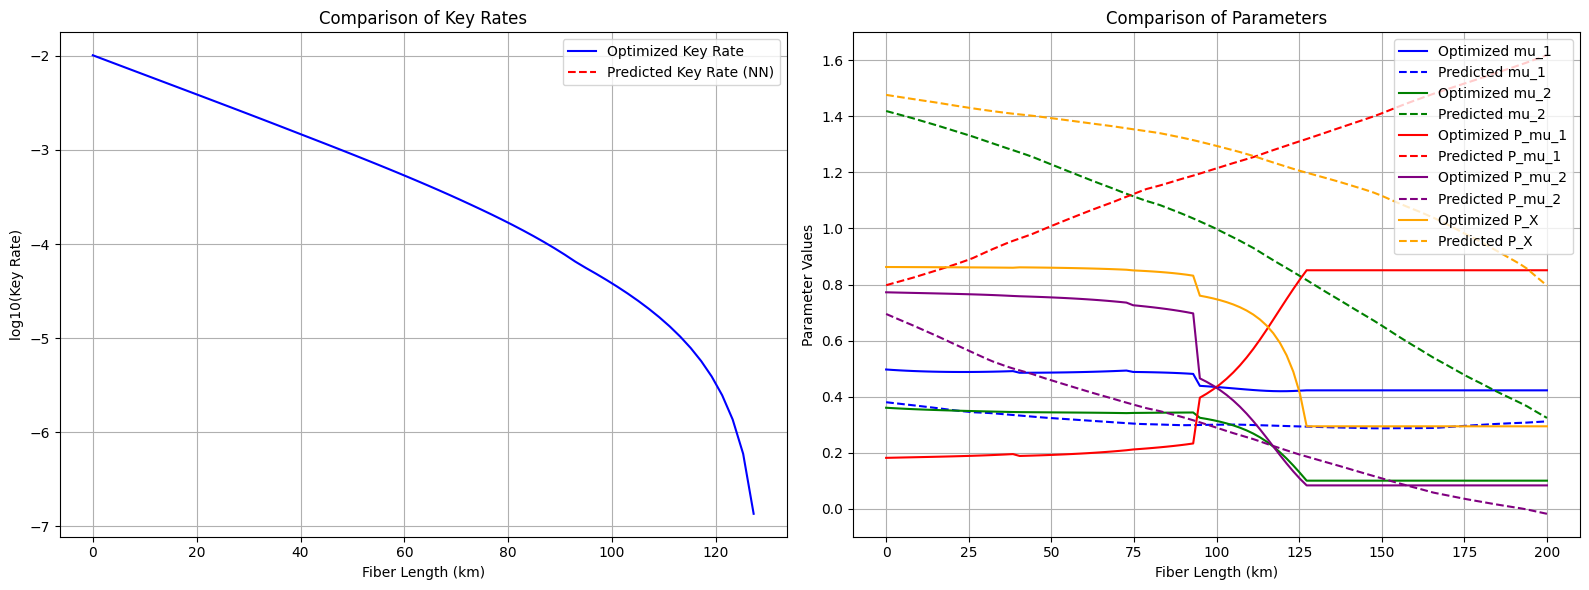

In [20]:
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
from QKD_Functions.QKD_Functions import objective

# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
model = BB84NN().to(device)
checkpoint = torch.load("best_model.pth", map_location=device)
model.load_state_dict(checkpoint)
model.eval()

# Load the dataset
with open("../Training_Data/single_nx/reordered_qkd_grouped_dataset_20250224_112957.json", 'r') as f:
    dataset = json.load(f)

# Select an n_X value
target_nx = 500000000
nx_key = str(float(target_nx))
if nx_key not in dataset:
    raise ValueError(f"No data found for n_X = {target_nx}")

optimized_data = dataset[nx_key]

# Extract fiber lengths, optimized key rates, and parameters
fiber_lengths = np.array([entry["fiber_length"] for entry in optimized_data])
optimized_key_rates = np.array([entry["key_rate"] for entry in optimized_data])
optimized_params_array = np.array([list(entry["optimized_params"].values()) for entry in optimized_data])

# Predict parameters and key rates
predicted_params_list = []
predicted_key_rates = []
for L in fiber_lengths:
    e_1 = L / 100
    e_2 = -np.log10(6e-7)
    e_3 = 5e-3 * 100
    e_4 = np.log10(target_nx)
    X = torch.tensor([[e_1, e_2, e_3, e_4]], dtype=torch.float32).to(device)
    
    with torch.no_grad():
        params = model(X).cpu().numpy()[0]
        predicted_params_list.append(params)
        key_rate = objective(params, L, target_nx, alpha=0.2, eta_Bob=0.1, P_dc_value=6e-7, epsilon_sec=1e-10, epsilon_cor=1e-15, f_EC=1.16, e_mis=5e-3, P_ap=4e-2, n_event=1)[0]
        predicted_key_rates.append(key_rate)

predicted_params_array = np.array(predicted_params_list)
predicted_key_rates = np.array(predicted_key_rates)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot key rates comparison on the left
ax1.plot(fiber_lengths, np.log10(optimized_key_rates), 'b-', label="Optimized Key Rate")
ax1.plot(fiber_lengths, np.log10(predicted_key_rates), 'r--', label="Predicted Key Rate (NN)")
ax1.set_title('Comparison of Key Rates')
ax1.set_xlabel('Fiber Length (km)')
ax1.set_ylabel('log10(Key Rate)')
ax1.legend()
ax1.grid(True)

# Plot parameters comparison on the right
labels = ['mu_1', 'mu_2', 'P_mu_1', 'P_mu_2', 'P_X']
colors = ['blue', 'green', 'red', 'purple', 'orange']
for i in range(5):
    ax2.plot(fiber_lengths, optimized_params_array[:, i], label=f'Optimized {labels[i]}', color=colors[i], linestyle='-')
    ax2.plot(fiber_lengths, predicted_params_array[:, i], label=f'Predicted {labels[i]}', color=colors[i], linestyle='--')

ax2.set_title('Comparison of Parameters')
ax2.set_xlabel('Fiber Length (km)')
ax2.set_ylabel('Parameter Values')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()